In [14]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import display
from functools import reduce
import operator

from common_plotting import read_data
from common_analysis import rel_data_cut_index_last, combine_stds_sum
from common_analysis_dcv import analyse_dcv, analyse_dcv_absolute, analyse_dcv_relative, analyse_dcv_k182, add_dut_neg_and_pos_group
from matplotlib import pyplot as plt

plt.rcParams["figure.figsize"] = (10,4)
plt.rc('font', size=14)

# Shared functions

In [2]:
def flatten_relative_dcv_result(rel_results: pd.DataFrame, mean: float, mean_sem:float):
    rows = rel_results.apply(lambda row: {
        (row.name, 'datetime'): row.datetime,
        (row.name, 'mean'): row.mean_in_ppm - mean,
        (row.name, 'sem'): combine_stds_sum(np.array(row.sem_in_ppm, mean_sem)) if not np.isnan(row.sem_in_ppm) else np.nan,
        (row.name, 'temperature'): row.temperature,
        (row.name, 'pressure'): row.pressure,
        (row.name, 'humidity'): row.humidity
        },
        axis=1)
    return reduce(operator.ior, rows, {})

def get_result_from_group(result, voltage_references):
    result = pd.concat([result, pd.DataFrame([{
        'mean_in_ppm': 0,
        'sem_in_ppm': combine_stds_sum(result.sem_in_ppm.dropna()),
        'datetime': result.datetime.mean(),
        'temperature': result.temperature.mean(),
        'pressure': result.pressure.mean(),
        'humidity': result.humidity.mean(),
        }], index=['F7001bat'])])
    results_wo_d4910avg = result[(result.index != 'D4910avg') & (result.index.isin(voltage_references))]
    population_mean = results_wo_d4910avg.mean_in_ppm.mean()
    if np.isnan(population_mean):
        return None
    population_sem = combine_stds_sum(results_wo_d4910avg.sem_in_ppm)
    # print(f"{result.datetime.mean()} mean: {population_mean}, sem: {population_sem}")
    flat_result = flatten_relative_dcv_result(result, population_mean, population_sem)
    return flat_result

# Load data

In [4]:
thp_data, data = read_data(['ks3458a1-dcv-log.csv', 'ks3458a1-dcv-mv-log.csv', 'k182-dcv-mv-log.csv', 'ks3458a-dcv-log.csv'])
absolute_data_3458a_1 = data['ks3458a1-dcv-log.csv']
absolute_data_3458a_2 = data['ks3458a-dcv-log.csv']
relative_data_3458a = data['ks3458a1-dcv-mv-log.csv']
relative_data_k182 = data['k182-dcv-mv-log.csv']


# Main analysis

In [5]:
from common_analysis import abs_data_cut_index_last


k182_rel_data_copy = relative_data_k182.copy()
k182_rel_data_copy['gap'] = k182_rel_data_copy.index.to_series().diff() > pd.Timedelta('3 hours')
k182_rel_data_copy['group'] = k182_rel_data_copy.gap.cumsum()
cut_1 = rel_data_cut_index_last(k182_rel_data_copy, 1, 'F732a2', 'D4910avg', pd.Timedelta('40 minutes'))
k182_rel_data_cut = k182_rel_data_copy[~cut_1].copy()
k182_rel_data_cut['gap'] = k182_rel_data_cut.index.to_series().diff() > pd.Timedelta('3 hours')
k182_rel_data_cut['group'] = k182_rel_data_cut.gap.cumsum()

ag3458a_rel_data = relative_data_3458a.copy()
ag3458a_rel_data['gap'] = ag3458a_rel_data.index.to_series().diff() > pd.Timedelta('3 hours')
ag3458a_rel_data['group'] = ag3458a_rel_data.gap.cumsum()

ag3458a_1_abs_data = absolute_data_3458a_1.copy()
ag3458a_1_abs_data['gap'] = ag3458a_1_abs_data.index.to_series().diff() > pd.Timedelta('3 hours')
ag3458a_1_abs_data['group'] = ag3458a_1_abs_data.gap.cumsum()
cut_1 = abs_data_cut_index_last(ag3458a_1_abs_data, 2, 'D4910avg', '10 V', pd.Timedelta('4 minutes'), pd.Timestamp('2021-11-17T21:38:19'))
cut_2 = (ag3458a_1_abs_data.index > pd.Timestamp('2021-11-17T23:49:12')) & (ag3458a_1_abs_data.index < pd.Timestamp('2022-04-18T21:35:20'))
cut_3 = (ag3458a_1_abs_data.index > pd.Timestamp('2022-04-19T02:11:40')) & (ag3458a_1_abs_data.index < pd.Timestamp('2022-08-09T22:49:55'))
ag3458a_1_abs_data_cut = ag3458a_1_abs_data[~cut_1 & ~cut_2 & ~cut_3].copy()
ag3458a_1_abs_data_cut['gap'] = ag3458a_1_abs_data_cut.index.to_series().diff() > pd.Timedelta('3 hours')
ag3458a_1_abs_data_cut['group'] = ag3458a_1_abs_data_cut.gap.cumsum()

cut_1 = (absolute_data_3458a_2.index > pd.Timestamp('2021-09-10T10:08:00')) & (absolute_data_3458a_2.index < pd.Timestamp('2021-09-12T22:17:24'))
ag3458a_2_abs_data = absolute_data_3458a_2[~cut_1].copy()
ag3458a_2_abs_data['gap'] = ag3458a_2_abs_data.index.to_series().diff() > pd.Timedelta('3 hours')
ag3458a_2_abs_data['group'] = ag3458a_2_abs_data.gap.cumsum()


In [6]:
voltage_references = ('F732a1', 'F732a2', 'F732a3', 'D4910avg', 'D4910-1', 'D4910-2', 'D4910-3', 'D4910-4', 'F7001bat')
columns = [(dut, param) for dut in voltage_references for param in ('datetime', 'mean', 'sem', 'temperature', 'pressure', 'humidity')]
results = []
for group in ag3458a_rel_data.group.unique():
    group_samples = ag3458a_rel_data[ag3458a_rel_data.group == group].copy()
    result = analyse_dcv_relative(group_samples, 'F7001bat', 10, 'F7001bat', 'ag3458a_1', 0)
    flat_result = get_result_from_group(result, voltage_references)
    if flat_result is None:
        continue
    results.append(flat_result)
for group in k182_rel_data_cut.group.unique():
    group_samples = k182_rel_data_cut[k182_rel_data_cut.group == group].copy()
    result = analyse_dcv_k182(group_samples)
    flat_result = get_result_from_group(result, voltage_references)
    if flat_result is None:
        continue
    results.append(flat_result)
orig_max_cols = pd.get_option('display.max_columns')
rel_results = pd.DataFrame(results, columns=pd.MultiIndex.from_tuples(columns))
pd.set_option('display.max_columns', None)
display(rel_results)
pd.set_option('display.max_columns', orig_max_cols)

F732a1                                   \
                        datetime       mean       sem temperature   
0  2022-08-10 02:42:04.326365952  17.186949  0.002508   34.877467   
1  2022-08-25 11:22:17.590431744  17.157302  0.002438   37.619157   
2                            NaT        NaN       NaN         NaN   
3  2022-08-29 14:37:56.017542400  17.011332  0.000651   37.508195   
4  2022-09-21 15:20:56.923994624  17.362201  0.003566   31.926506   
5  2022-12-22 21:38:08.994086400  17.488942  0.003949   27.895061   
6  2023-01-14 18:56:41.392179712  17.824152  0.003604   25.945197   
7  2023-01-22 01:19:35.432957440  17.684561  0.004085   24.418316   
8  2023-01-25 22:41:22.304952832  17.767971  0.004745   25.170996   
9                            NaT        NaN       NaN         NaN   
10 2023-01-27 23:36:17.341893120  17.620580  0.003345   28.350979   
11                           NaT        NaN       NaN         NaN   
12 2023-01-28 15:07:23.155353088  17.308609  0.003931   31.665460   
13 2023-03-02 01:59:41.804903168  17.635065  0.003806   28.327617   
14 2023-06-24 21:42:10.059316224  17.524413  0.003318   32.858124   
15 2023-07-16 20:50:56.948048384  17.805266  0.002518   33.153038   
16 2023-07-22 23:25:36.147859968  17.788463  0.003867   33.801844   

                                                  F732a2                       \
       pressure   humidity                      datetime       mean       sem   
0   1027.884677  31.436515 2022-08-10 03:01:26.240461824  14.476606  0.003114   
1   1015.337532  28.855276 2022-08-25 11:38:27.978521344  14.440377  0.003885   
2           NaN        NaN                           NaT        NaN       NaN   
3   1022.579408  23.654013 2022-08-29 13:43:49.964445696  14.360062  0.000814   
4   1026.429435  22.709645 2022-09-21 15:28:52.841974784  14.710786  0.003241   
5   1002.113863  33.452271 2022-12-22 21:34:38.862407168  14.731516  0.004298   
6    995.474800  36.025571 2023-01-14 18:53:07.648848896  15.017771  0.004221   
7   1034.795595  27.565945 2023-01-22 01:24:01.665231104  14.944496  0.001685   
8   1025.835012  26.277449 2023-01-26 00:26:54.946850304  14.934590  0.008860   
9           NaN        NaN 2023-01-26 08:23:30.832382208  20.269159  0.007190   
10  1030.047550  27.095842 2023-01-27 23:28:51.173477376  14.902803  0.004598   
11          NaN        NaN 2023-01-28 06:06:57.842015232  20.277736  0.005398   
12  1030.152193  25.268042 2023-01-28 15:03:11.508902912  14.510012  0.005300   
13  1025.493539  22.894800 2023-03-02 01:56:20.820233728  14.840549  0.004686   
14  1021.945571  33.201811 2023-06-24 21:35:13.448096768  14.652576  0.004468   
15  1013.870446  30.129140 2023-07-16 20:44:57.703027456  14.910612  0.002956   
16  1009.919901  32.507132 2023-07-22 23:30:20.788241408  14.812076  0.003170   

                                                              F732a3  \
   temperature     pressure   humidity                      datetime   
0    34.819442  1027.887984  31.265190 2022-08-10 02:51:34.409591808   
1    37.677573  1015.255665  28.696644 2022-08-25 11:44:08.448907520   
2          NaN          NaN        NaN                           NaT   
3    37.120882  1022.884395  23.581948 2022-08-29 11:25:53.247917056   
4    32.455406  1026.352040  21.831325 2022-09-21 15:24:50.224551680   
5    27.719199  1002.049425  33.660435 2022-12-22 21:42:19.887340032   
6    25.936919   995.468495  35.979581 2023-01-14 18:50:16.263861248   
7    24.285600  1034.790586  27.475825 2023-01-22 01:36:55.545875712   
8    24.652354  1025.155756  25.828323 2023-01-26 00:12:51.405470720   
9    26.475819  1025.229465  28.487566 2023-01-26 08:25:27.378796032   
10   28.508733  1030.139306  26.883538 2023-01-27 23:32:20.678178304   
11   28.210090  1030.512973  27.087796 2023-01-28 06:09:22.856514560   
12   31.562729  1030.144740  25.193714 2023-01-28 14:58:13.347951616   
13   28.426128  1025.530239  22.618610 2023-03-02 01:53:24.803950592   
14   32.525971  1021.9

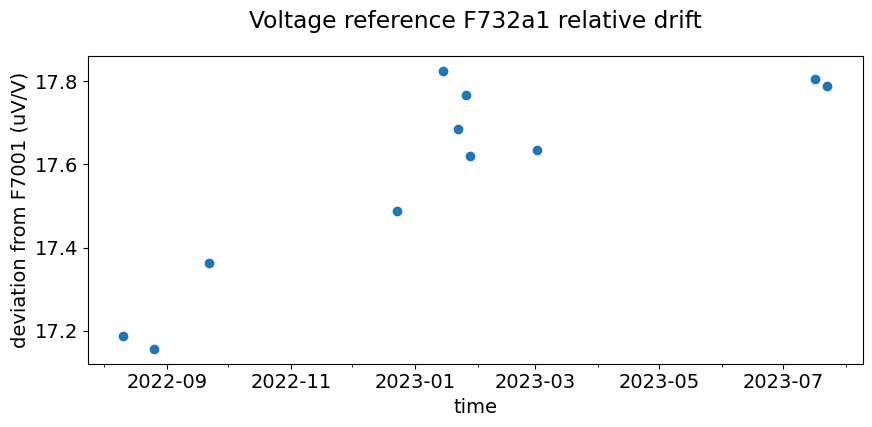

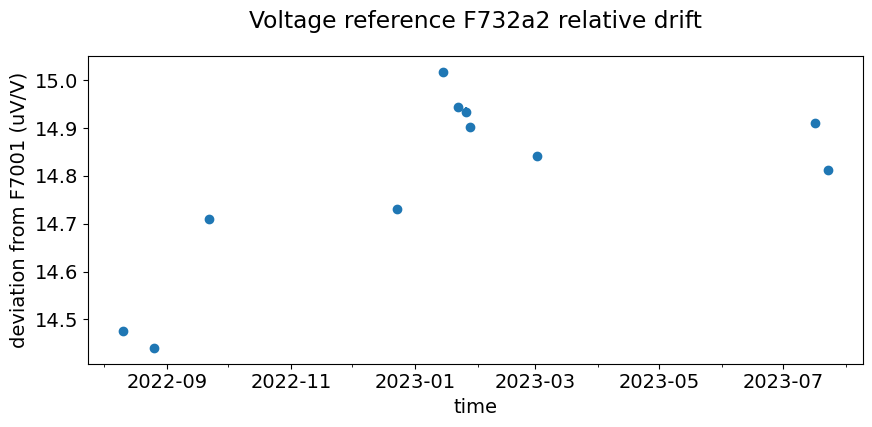

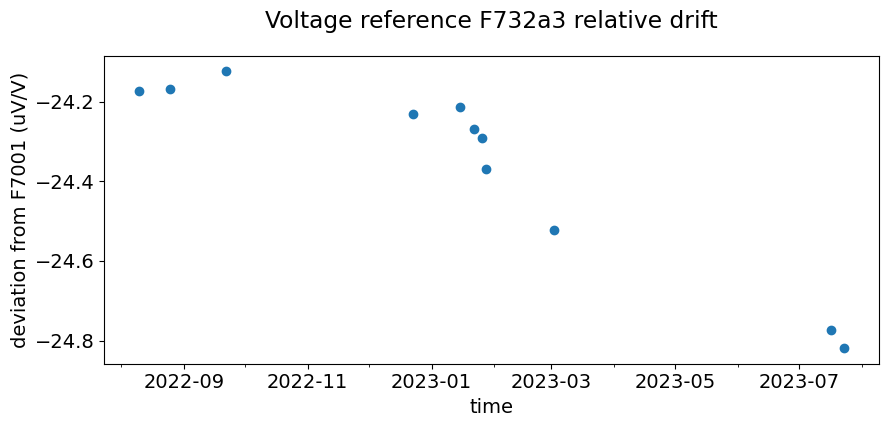

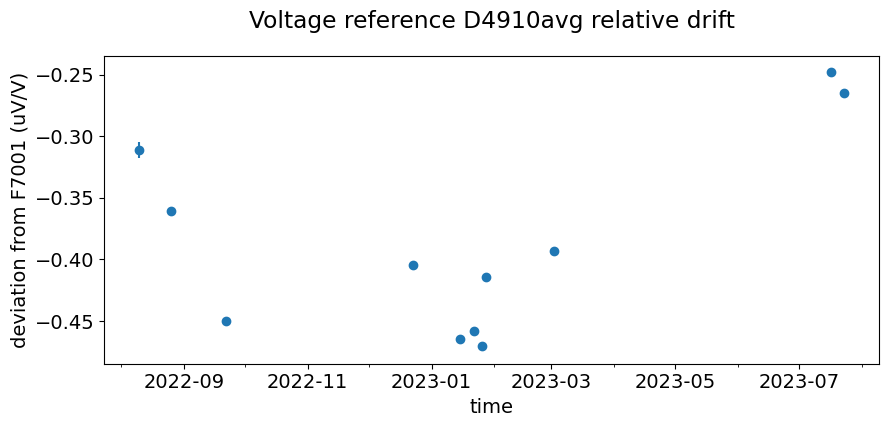

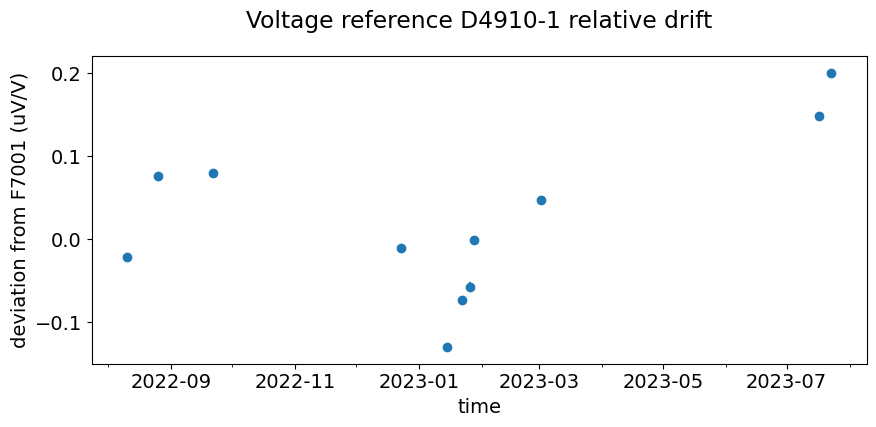

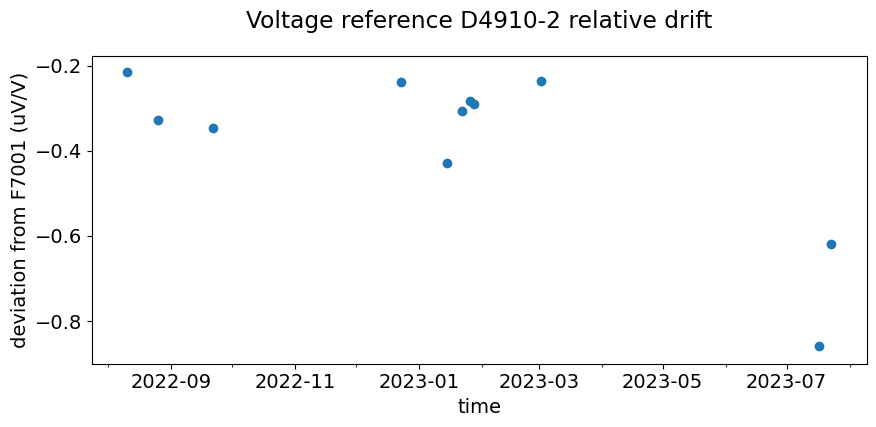

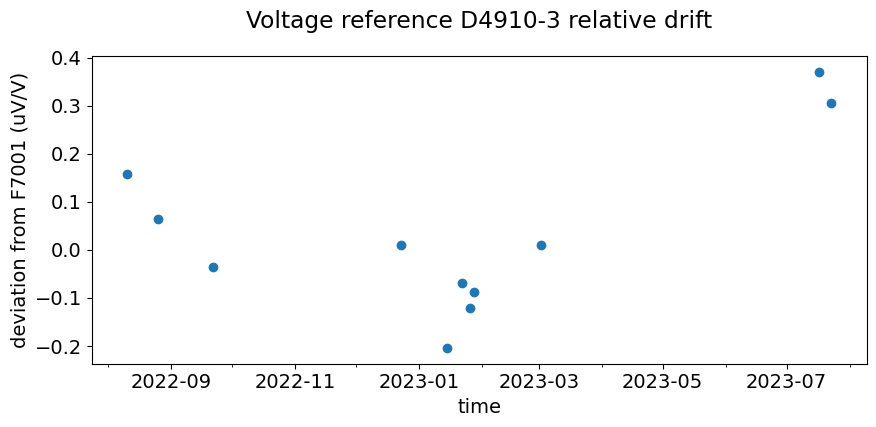

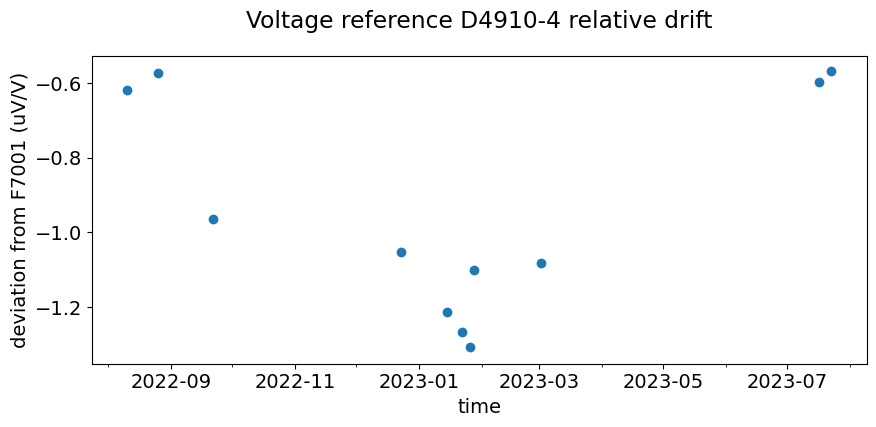

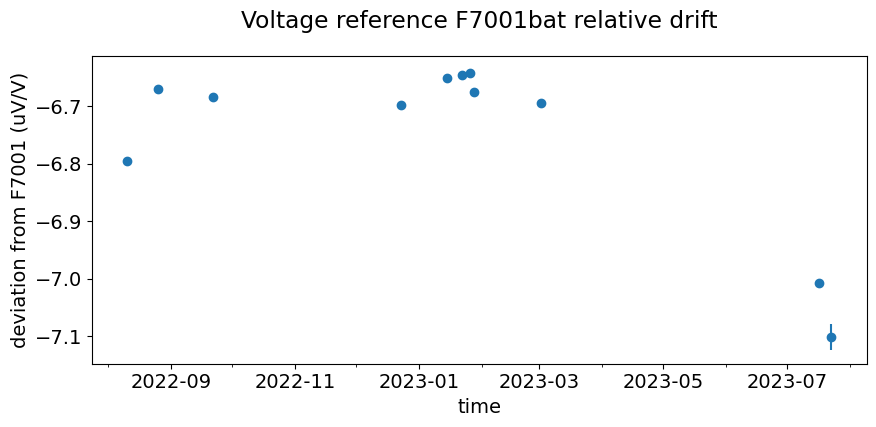

In [7]:
plt.rcParams["figure.figsize"] = (10,4)

# rel_results[[(ref, param) for ref in voltage_references for param in ('mean', 'sem', 'datetime')]]
rel_results = rel_results.dropna()
for ref in voltage_references:  
    plt.errorbar(rel_results[(ref, 'datetime')].dropna(), rel_results[(ref, 'mean')].dropna(), yerr=rel_results[(ref, 'sem')].dropna(), label=ref, fmt='o')
    plt.xlabel('time')
    plt.ylabel('deviation from F7001 (uV/V)')
    plt.title(f'Voltage reference {ref} relative drift', pad=20)
    ax = plt.gca()
    ax.xaxis.set_major_locator(mdates.MonthLocator(interval=2))
    ax.xaxis.set_minor_locator(mdates.MonthLocator(interval=1))
    plt.show()

# Misc analyses

## Check groupings

### k182_relative_data

In [8]:
orig_max_rows = pd.get_option('display.max_rows')
pd.set_option('display.max_rows', None)
duration_data = k182_rel_data_cut.reset_index().groupby(['group', 'dut_neg_lead', 'dut_pos_lead']).agg({'datetime': ['min', 'max']})
duration_data['duration'] = duration_data['datetime']['max'] - duration_data['datetime']['min']
display(duration_data.sort_values(('datetime', 'min')))
pd.set_option('display.max_rows', orig_max_rows)

datetime  \
                                                       min   
group dut_neg_lead dut_pos_lead                              
0     F732a3       short        2022-08-25 10:54:36.345585   
      F7001bat     F732a3       2022-08-25 11:10:49.192938   
      F732a3       F7001bat     2022-08-25 11:11:47.817884   
      F7001bat     F732a2       2022-08-25 11:15:00.538933   
      F732a2       F7001bat     2022-08-25 11:16:11.098328   
      F7001bat     F732a1       2022-08-25 11:19:30.916404   
      F732a1       F7001bat     2022-08-25 11:21:42.822080   
      D4910avg     F7001bat     2022-08-25 12:17:05.303089   
      F7001bat     D4910avg     2022-08-25 12:19:05.447746   
                   D4910-1      2022-08-25 12:20:48.426500   
      D4910-1      F7001bat     2022-08-25 12:26:34.963214   
      D4910-2      F7001bat     2022-08-25 12:27:26.435180   
      F7001bat     D4910-2      2022-08-25 12:29:13.876519   
                   D4910-3      2022-08-25 12:30:06.651368   
      D4910-3      F7001bat     2022-08-25 12:31:39.562114   
      D4910-4      F7001bat     2022-08-25 12:33:50.013982   
      F7001bat     D4910-4      2022-08-25 12:36:06.086554   
1     F7001bat     D4910avg     2022-08-25 18:20:26.367591   
      D4910avg     F7001bat     2022-08-25 18:28:26.620399   
2     F732a2       D4910avg     2022-08-29 08:24:27.698550   
      D4910avg     F732a2       2022-08-29 09:05:19.275537   
                   F732a1       2022-08-29 09:46:38.423818   
      F732a1       D4910avg     2022-08-29 10:23:36.217180   
      F732a3       F7001bat     2022-08-29 11:19:20.572905   
      F7001bat     F732a3       2022-08-29 11:24:27.275045   
                   F732a2       2022-08-29 13:20:08.519553   
      F732a2       F7001bat     2022-08-29 13:36:40.005940   
      F7001bat     F732a1       2022-08-29 14:24:28.700846   
                   D4910avg     2022-08-29 15:56:30.117154   
      D4910avg     F7001bat     2022-08-29 16:47:43.705942   
      D4910-1      D4910avg     2022-08-29 23:16:06.756243   
      D4910avg     D4910-1      2022-08-30 00:03:44.611842   
                   D4910-2      2022-08-30 01:08:43.225209   
      D4910-2      D4910avg     2022-08-30 01:11:56.610067   
      D4910avg     D4910-3      2022-08-30 02:02:11.645479   
      D4910-3      D4910avg     2022-08-30 02:05:56.078102   
      D4910-4      D4910avg     2022-08-30 02:13:12.098882   
      D4910avg     D4910-4      2022-08-30 02:17:44.706268   
3     F732a3       short        2022-09-21 14:38:34.325989   
      F7001bat     D4910avg     2022-09-21 14:48:40.506780   
      D4910avg     F7001bat     2022-09-21 14:53:10.954148   
      D4910-1      F7001bat     2022-09-21 15:01:32.390421   
      F7001bat     D4910-1      2022-09-21 15:03:24.326789   
                   D4910-2      2022-09-21 15:04:27.639280   
      D4910-2      F7001bat     2022-09-21 15:06:25.984446   
      D4910-3      F7001bat     2022-09-21 15:07:40.944958   
      F7001bat     D4910-3      2022-09-21 15:09:44.265395   
                   D4910-4      2022-09-21 15:11:24.770328   
      D4910-4      F7001bat     2022-09-21 15:13:17.946008   
      F7001bat     F732a1       2022-09-21 15:19:34.270207   
      F732a1       F7001bat     2022-09-21 15:21:18.670737   
      F732a3       F7001bat     2022-09-21 15:23:26.190168   
      F7001bat     F732a3       2022-09-21 15:25:06.640846   
                   F732a2       2022-09-21 15:27:18.073584   
      F732a2       F7001bat     2022-09-21 15:29:06.014125   
      D4910-1      D4910avg     2022-09-21 15:35:32.709221   
      D4910avg     D4910-1      2022-09-21 15:41:21.479444   
                   D4910-2      2022-09-21 15:44:13.689125   
      D4910-2      D4910avg     2022-09-21 15:45:48.785402   
      D4910-3      D4910avg     2022-09-21 15:47:29.091510   
      D4910avg     D4910-3      2022-09-21 15:49:10.036465   
                   D4910-4      2022-09-21 15:50:41.859278   
      D4910-4      D

### ag3458a_rel_data

In [9]:
orig_max_rows = pd.get_option('display.max_rows')
pd.set_option('display.max_rows', None)
duration_data = ag3458a_rel_data.reset_index().groupby(['group', 'dut_neg_lead', 'dut_pos_lead']).agg({'datetime': ['min', 'max']})
duration_data['duration'] = duration_data['datetime']['max'] - duration_data['datetime']['min']
display(duration_data.sort_values(('datetime', 'min')))
pd.set_option('display.max_rows', orig_max_rows)

datetime  \
                                                       min   
group dut_neg_lead dut_pos_lead                              
0     D4910avg     F7001bat     2022-08-10 01:28:59.711916   
      F7001bat     D4910avg     2022-08-10 01:33:52.224816   
                   D4910-1      2022-08-10 01:44:02.558776   
      D4910-1      F7001bat     2022-08-10 01:51:36.222159   
      D4910-2      F7001bat     2022-08-10 01:59:20.068137   
      F7001bat     D4910-2      2022-08-10 02:06:14.304998   
                   D4910-3      2022-08-10 02:09:04.730457   
      D4910-3      F7001bat     2022-08-10 02:14:15.811525   
      D4910-4      F7001bat     2022-08-10 02:17:17.205464   
      F7001bat     D4910-4      2022-08-10 02:20:17.535474   
      F732a1       F7001bat     2022-08-10 02:38:57.622169   
      F7001bat     F732a1       2022-08-10 02:43:22.142429   
                   F732a3       2022-08-10 02:48:29.379110   
      F732a3       F7001bat     2022-08-10 02:52:15.031834   
      F732a2       F7001bat     2022-08-10 02:56:37.414828   
      F7001bat     F732a2       2022-08-10 03:03:27.922068   

                                                            \
                                                       max   
group dut_neg_lead dut_pos_lead                              
0     D4910avg     F7001bat     2022-08-10 03:18:04.621361   
      F7001bat     D4910avg     2022-08-10 03:12:03.621322   
                   D4910-1      2022-08-10 01:50:18.250952   
      D4910-1      F7001bat     2022-08-10 01:54:08.639030   
      D4910-2      F7001bat     2022-08-10 02:01:01.371553   
      F7001bat     D4910-2      2022-08-10 02:08:26.091012   
                   D4910-3      2022-08-10 02:11:31.643546   
      D4910-3      F7001bat     2022-08-10 02:16:12.291561   
      D4910-4      F7001bat     2022-08-10 02:19:03.577417   
      F7001bat     D4910-4      2022-08-10 02:22:31.001556   
      F732a1       F7001bat     2022-08-10 02:40:33.865399   
      F7001bat     F732a1       2022-08-10 02:45:23.708859   
                   F732a3       2022-08-10 02:50:51.225480   
      F732a3       F7001bat     2022-08-10 02:54:42.003983   
      F732a2       F7001bat     2022-08-10 02:59:14.445236   
      F7001bat     F732a2       2022-08-10 03:06:25.205327   

                                              duration  
                                                        
group dut_neg_lead dut_pos_lead                         
0     D4910avg     F7001bat     0 days 01:49:04.909445  
      F7001bat     D4910avg     0 days 01:38:11.396506  
                   D4910-1      0 days 00:06:15.692176  
      D4910-1      F7001bat     0 days 00:02:32.416871  
      D4910-2      F7001bat     0 days 00:01:41.303416  
      F7001bat     D4910-2      0 days 00:02:11.786014  
                   D4910-3      0 days 00:02:26.913089  
      D4910-3      F7001bat     0 days 00:01:56.480036  
      D4910-4      F7001bat     0 days 00:01:46.371953  
      F7001bat     D4910-4      0 days 00:02:13.466082  
      F732a1       F7001bat     0 days 00:01:36.243230  
      F7001bat     F732a1       0 days 00:02:01.566430  
                   F732a3       0 days 00:02:21.846370  
      F732a3       F7001bat     0 days 00:02:26.972149  
      F732a2       F7001bat     0 days 00:02:37.030408  
      F7001bat     F732a2       0 days 00:02:57.283259

### ag3458a_1_abs_data

In [10]:
orig_max_rows = pd.get_option('display.max_rows')
pd.set_option('display.max_rows', None)
duration_data = ag3458a_1_abs_data_cut.reset_index().groupby(['group', 'dut']).agg({'datetime': ['min', 'max']})
duration_data['duration'] = duration_data['datetime']['max'] - duration_data['datetime']['min']
display(duration_data.sort_values(('datetime', 'min')))
pd.set_option('display.max_rows', orig_max_rows)
np.unique(ag3458a_1_abs_data_cut[ag3458a_1_abs_data_cut.group == 2].index.date)

datetime                             \
                                            min                        max   
group dut                                                                    
0     D4910avg       2021-09-13 01:13:07.779134 2021-09-13 01:19:14.231825   
1     D4910avg       2021-11-15 12:02:46.347705 2021-11-15 13:59:46.780667   
2     D4910avg       2021-11-17 21:34:21.608514 2021-11-17 23:41:11.154469   
      D4910-1        2021-11-17 21:43:40.639165 2021-11-17 21:51:22.598264   
      D4910-2        2021-11-17 21:52:13.707073 2021-11-17 22:00:23.203927   
      D4910-3        2021-11-17 22:01:03.708580 2021-11-17 22:13:02.082328   
      D4910-4        2021-11-17 22:14:23.978300 2021-11-17 22:23:06.585416   
      F7001          2021-11-17 22:48:06.302977 2021-11-17 22:55:54.455700   
      F732a1         2021-11-17 22:56:50.634225 2021-11-17 23:05:05.076983   
      F732a3         2021-11-17 23:06:15.396853 2021-11-17 23:15:29.717624   
      F732a2         2021-11-17 23:16:40.332361 2021-11-17 23:30:06.268242   
      F7001bat       2021-11-17 23:42:01.955847 2021-11-17 23:49:11.342004   
3     D4910avg       2022-04-18 21:35:24.253048 2022-04-19 02:11:31.926951   
      F732a1         2022-04-18 21:54:32.069056 2022-04-18 22:11:46.404381   
      F732a2         2022-04-18 22:14:01.739416 2022-04-18 22:25:24.321413   
      F7001          2022-04-18 22:38:34.637707 2022-04-19 00:13:40.879587   
      F732a3         2022-04-19 00:22:14.733987 2022-04-19 00:46:12.733832   
      D4910-1        2022-04-19 01:09:49.794657 2022-04-19 01:22:03.071756   
      D4910-2        2022-04-19 01:23:23.510141 2022-04-19 01:34:11.820142   
      D4910-3        2022-04-19 01:35:26.978687 2022-04-19 01:43:02.342169   
      D4910-4        2022-04-19 01:44:21.125066 2022-04-19 01:54:20.876938   
4     F7001          2022-08-09 22:49:59.001239 2022-08-09 22:57:51.840841   
      F7001bat       2022-08-09 22:57:56.888908 2022-08-10 01:13:46.512001   
      D4910avg       2022-08-09 23:11:15.475188 2022-08-10 01:04:53.725476   
      F732a2         2022-08-09 23:32:39.433347 2022-08-09 23:37:20.953583   
      F732a3         2022-08-09 23:42:32.575772 2022-08-09 23:46:56.333309   
      F732a1         2022-08-09 23:54:17.381498 2022-08-09 23:59:49.880619   
      D4910-1        2022-08-10 00:08:25.421378 2022-08-10 00:14:41.379323   
      D4910-2        2022-08-10 00:23:37.371235 2022-08-10 00:28:10.501296   
      D4910-3        2022-08-10 00:37:51.230448 2022-08-10 00:42:20.643407   
      D4910-4        2022-08-10 00:49:39.430725 2022-08-10 00:54:22.437404   
5     F7001bat       2022-08-12 20:23:16.362595 2022-08-13 01:56:29.962644   
      D4910avg       2022-08-12 23:33:56.978725 2022-08-13 01:41:02.817084   
      D4910-1        2022-08-12 23:44:01.438880 2022-08-12 23:54:10.968391   
      D4910-2        2022-08-12 23:55:06.818814 2022-08-13 00:05:46.047200   
      D4910-3        2022-08-13 00:07:20.747765 2022-08-13 00:15:26.812397   
      D4910-4        2022-08-13 00:16:34.334437 2022-08-13 00:24:49.311552   
      F732a1         2022-08-13 00:39:14.224866 2022-08-13 00:51:23.760087   
      F732a3         2022-08-13 00:52:12.107446 2022-08-13 01:01:28.460971   
      F732a2         2022-08-13 01:02:28.506413 2022-08-13 01:12:43.821193   
6     F7001          2022-08-18 21:24:14.111876 2022-08-18 21:52:06.811048   
7     D4910avg       2022-08-25 10:53:22.675539 2022-08-25 18:16:43.043366   
      F7001bat       2022-08-25 10:56:58.262390 2022-08-25 17:58:58.121035   
      D4910-1        2022-08-25 11:14:46.875533 2022-08-25 11:19:40.736179   
      D4910-2        2022-08-25 11:20:27.211773 2022-08-25 11:25:48.278622   
      D4910-3        2022-08-25 11:26:40.670103 2022-08-25 11:40:40.547632   
      D4910-4        2022-08-25 11:41:07.974949 2022-08-25 11:47:43.737021   
      F732a1         2022-08-25 11:58:35.077337 2022-08-25 12:39:56.297582   
      F732a3         2022-08-25 12:13:42.901758 2022-08-25 12

array([datetime.date(2021, 11, 17)], dtype=object)

### ag3458a_2_abs_data

In [11]:
orig_max_rows = pd.get_option('display.max_rows')
pd.set_option('display.max_rows', None)
duration_data = ag3458a_2_abs_data.reset_index().groupby(['group', 'dut']).agg({'datetime': ['min', 'max']})
duration_data['duration'] = duration_data['datetime']['max'] - duration_data['datetime']['min']
display(duration_data.sort_values(('datetime', 'min')))
pd.set_option('display.max_rows', orig_max_rows)

datetime  \
                                                min   
group dut                                             
0     F7001-SMPS-Au799ln 2021-09-10 10:01:16.672755   
      F732a2             2021-09-10 10:03:24.330000   
      D4910avg           2021-09-10 10:04:52.182880   
1     D4910avg           2021-09-12 22:17:33.380947   
      F7001              2021-09-12 22:43:20.135285   
      F7001-SMPS-Au799ln 2021-09-12 22:51:43.314149   
      F732a2             2021-09-12 23:01:35.691370   
      F732a1             2021-09-12 23:06:29.808999   
      F732a3             2021-09-12 23:12:47.715171   
2     F7001bat           2022-12-25 02:39:14.842788   
3     F7001bat           2023-07-17 01:54:35.303091   

                                                                  duration  
                                                max                         
group dut                                                                   
0     F7001-SMPS-Au799ln 2021-09-10 10:02:37.092581 0 days 00:01:20.419826  
      F732a2             2021-09-10 10:03:54.487813 0 days 00:00:30.157813  
      D4910avg           2021-09-10 10:07:53.086176 0 days 00:03:00.903296  
1     D4910avg           2021-09-13 01:39:51.978332 0 days 03:22:18.597385  
      F7001              2021-09-12 23:35:48.901632 0 days 00:52:28.766347  
      F7001-SMPS-Au799ln 2021-09-12 22:56:34.825195 0 days 00:04:51.511046  
      F732a2             2021-09-12 23:31:53.970455 0 days 00:30:18.279085  
      F732a1             2021-09-12 23:27:52.888710 0 days 00:21:23.079711  
      F732a3             2021-09-12 23:23:01.281511 0 days 00:10:13.566340  
2     F7001bat           2022-12-25 03:00:32.842690 0 days 00:21:17.999902  
3     F7001bat           2023-07-17 02:11:27.059450 0 days 00:16:51.756359

In [12]:
"""
k199-x2-3458A-x1-F732A-MV106-log.csv.bz2
datetime,k199_1_f732a_mv106,k199_2_f732a_therm,ag3458a_1_f732a,temp_1,last_acal_1,last_acal_1_cal72
2020-04-26
2020-10-14
k199-x2-3458A-x1-k2000-x2-6031A-D4910-F732A-x3-log.csv.bz2
datetime,k199_1_d4910_avg_2,k199_2_d4910_avg_3,temp_1,last_acal_1,last_acal_1_cal72,ag3458a_1_d4910_avg_f732a3,k2000_d4910_avg_4,k2000_20_d4910_avg_1,prema6031a_d4910_avg_f732a2
2021-04-18
2021-08-07
k199-x2-3458A-x2-F732A-MV106-log.csv.bz2
datetime,k199_1_f732a_mv106,k199_2_f732a_therm,ag3458a_1_f732a,temp_1,last_acal_1,last_acal_1_cal72,ag3458a_2_f732a,temp_2,last_acal_2,last_acal_2_cal72
2018-12-08
2020-04-26
k199-x2-3458A-x2-k2000-x2-6031A-D4910-F732A-x2-F7001-log.csv.bz2
datetime,k199_1_d4910_avg_2,k199_2_d4910_avg_3,temp_1,last_acal_1,last_acal_1_cal72,ag3458a_1_d4910_avg_f732a3,temp_2,last_acal_2,last_acal_2_cal72,ag3458a_2_d4910_avg_f7001,k2000_d4910_avg_4,k2000_20_d4910_avg_1,prema6031a_d4910_avg_f732a2
2021-08-07
2021-08-31
k199-x2-3458A-x2-k2000-x2-6031A-D4910-F732A-x3-F7001-log.csv.bz2
datetime,k199_1_d4910_avg_2,k199_2_d4910_avg_3,temp_1,last_acal_1,last_acal_1_cal72,ag3458a_1_d4910_avg_f732a3,temp_2,last_acal_2,last_acal_2_cal72,ag3458a_2_d4910_avg_f7001,k2000_d4910_avg_f732a1,k2000_20_d4910_avg_1,prema6031a_d4910_avg_f732a2
2021-09-09
2021-09-10
k199-x2-3458A-x2-k2000-x2-D4910-F732A-MV106-log.csv.bz2
datetime,k199_1_f732a_mv106,k199_2_d4910_avg_4,ag3458a_1_d4910_avg_3,temp_1,last_acal_1,last_acal_1_cal72,ag3458a_2_f732a_d4910_avg,temp_2,last_acal_2,last_acal_2_cal72,k2000_d4910_avg_1,k2000_20_d4910_avg_2
2020-10-14
2020-12-20
k199-x2-3458A-x2-k2000-x2-D4910-F732A-x2-log.csv.bz2
datetime,k199_1_d4910_avg_2,k199_2_d4910_avg_3,ag3458a_2_f732a2_d4910_avg,temp_1,last_acal_1,last_acal_1_cal72,ag3458a_1_f732a1_d4910_avg,temp_2,last_acal_2,last_acal_2_cal72,k2000_d4910_avg_4,k2000_20_d4910_avg_1
2020-12-21
2021-04-03
k199-x2-3458A-x2-k2000-x-D4910-F732A-MV106-log.csv.bz2
datetime,k199_1_f732a_mv106,k199_2_d4910_avg_4,ag3458a_1_d4910_avg_3,temp_1,last_acal_1,last_acal_1_cal72,ag3458a_2_f732a_d4910_avg,temp_2,last_acal_2,last_acal_2_cal72,k2000_d4910_avg_1,k2000_20_d4910_avg_2
2020-10-14
2020-10-14

3458A-x2-MV106.csv.bz2
datetime,ag3458a_1_mv106,temp_1,last_acal_1,last_acal_1_cal72,ag3458a_2_mv106,temp_2,last_acal_2,last_acal_2_cal72
2018-06-30
2018-12-08
k199-x2-3456A-3458A-x2-F730A-6031A-8200-log.csv.bz2
datetime,ag3456a_ch1_2,k199_ch1_3,k199_ch1_4,ag3458a_1_ch1,temp_1,last_acal_1,last_acal_1_cal72,pr6031a_8200,ag3458a_2_ch1,temp_2,last_acal_2,last_acal_2_cal72
2018-02-27
2018-03-03
k199-x2-3458A-x2-F730A-6031A-8200-log.csv.bz2
datetime,k199_ch1_3,k199_ch1_4,ag3458a_1_ch1,temp_1,last_acal_1,last_acal_1_cal72,pr6031a_8200,ag3458a_2_ch1,temp_2,last_acal_2,last_acal_2_cal72
2018-03-03
2018-03-04
k199-x2-3458A-x2-F730A-PM2534-log.csv.bz2
datetime,pm2534_ch1_2,k199_ch1_3,k199_ch1_4,ag3458a_1_ch1,temp_1,last_acal_1,last_acal_1_cal72,ag3458a_2_ch1,temp_2,last_acal_2,last_acal_2_cal72
2018-03-04
2018-03-31

"""

"""
k199-x2-3456A-3458A-x2-F730A-6031A-8200-log.csv.bz2
2018-02-27 - 2018-03-03: 2x 3458A
k199-x2-3458A-x2-F730A-6031A-8200-log.csv.bz2
2018-03-03 - 2018-03-04: 2x 3458A
k199-x2-3458A-x2-F730A-PM2534-log.csv.bz2
2018-03-04 - 2018-03-31: 2x 3458A
3458A-x2-MV106.csv.bz2
2018-06-30 - 2018-12-08: 2x 3458A
k199-x2-3458A-x2-F732A-MV106-log.csv.bz2
2018-12-08 - 2020-04-26: 2x 3458A, 1x F732A
k199-x2-3458A-x1-F732A-MV106-log.csv.bz2
2020-04-26 - 2020-10-14: 1x 3458A(_1), 1x F732A
k199-x2-3458A-x2-k2000-x-D4910-F732A-MV106-log.csv.bz2
k199-x2-3458A-x2-k2000-x2-D4910-F732A-MV106-log.csv.bz2
2020-10-14 - 2020-12-20: 2x 3458A, 1x F732A, D4910 avg, 1-4
k199-x2-3458A-x2-k2000-x2-D4910-F732A-x2-log.csv.bz2
2020-12-21 - 2021-04-03: 2x 3458A, 2x F732A, D4910 avg, 1-4
k199-x2-3458A-x1-k2000-x2-6031A-D4910-F732A-x3-log.csv.bz2
2021-04-18 - 2021-08-07: 1x 3458A(-1), 3x F732A, D4910 avg, 1-4
k199-x2-3458A-x2-k2000-x2-6031A-D4910-F732A-x2-F7001-log.csv.bz2
2021-08-07 - 2021-08-31: 2x 3458A, 2x F732A, D4910 avg, 1-4, F7001
k199-x2-3458A-x2-k2000-x2-6031A-D4910-F732A-x3-F7001-log.csv.bz2
2021-09-09 - 2021-09-10: 2x 3458A, 3x F732A, D4910 avg, 1-3, F7001
"""

'\nk199-x2-3456A-3458A-x2-F730A-6031A-8200-log.csv.bz2\n2018-02-27 - 2018-03-03: 2x 3458A\nk199-x2-3458A-x2-F730A-6031A-8200-log.csv.bz2\n2018-03-03 - 2018-03-04: 2x 3458A\nk199-x2-3458A-x2-F730A-PM2534-log.csv.bz2\n2018-03-04 - 2018-03-31: 2x 3458A\n3458A-x2-MV106.csv.bz2\n2018-06-30 - 2018-12-08: 2x 3458A\nk199-x2-3458A-x2-F732A-MV106-log.csv.bz2\n2018-12-08 - 2020-04-26: 2x 3458A, 1x F732A\nk199-x2-3458A-x1-F732A-MV106-log.csv.bz2\n2020-04-26 - 2020-10-14: 1x 3458A(_1), 1x F732A\nk199-x2-3458A-x2-k2000-x-D4910-F732A-MV106-log.csv.bz2\nk199-x2-3458A-x2-k2000-x2-D4910-F732A-MV106-log.csv.bz2\n2020-10-14 - 2020-12-20: 2x 3458A, 1x F732A, D4910 avg, 1-4\nk199-x2-3458A-x2-k2000-x2-D4910-F732A-x2-log.csv.bz2\n2020-12-21 - 2021-04-03: 2x 3458A, 2x F732A, D4910 avg, 1-4\nk199-x2-3458A-x1-k2000-x2-6031A-D4910-F732A-x3-log.csv.bz2\n2021-04-18 - 2021-08-07: 1x 3458A(-1), 3x F732A, D4910 avg, 1-4\nk199-x2-3458A-x2-k2000-x2-6031A-D4910-F732A-x2-F7001-log.csv.bz2\n2021-08-07 - 2021-08-31: 2x 3458

## Check number of samples taken

In [15]:
rel_counts = add_dut_neg_and_pos_group(relative_data_k182).groupby('group')['dut_neg_lead'].count()

<Axes: ylabel='Frequency'>

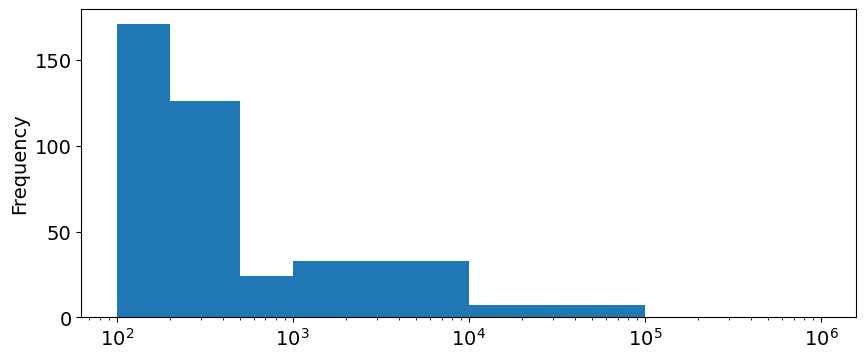

In [16]:
rel_counts.plot(kind="hist", logx=True, bins=[100,200, 500, 1e3,1e4,1e5,1e6])

In [17]:
relative_data_k182.groupby(by=['dut_pos_lead', 'dut_neg_lead']).count()

k182_dcv  temperature  pressure  humidity
dut_pos_lead dut_neg_lead                                           
D4190-3      D4910avg           191          191       191       191
D4190-4      D4910avg           201          201       201       201
D4700+10V    F7001bat           639          639       639       639
D4700-10V    F7001bat           817          817       817       817
D4910-1      D4910avg         11760        11760     11760     11760
             F7001bat          3417         3417      3417      3417
D4910-2      D4910avg          8322         8322      8322      8322
             F7001bat          2095         2095      2095      2095
D4910-3      D4910avg          3619         3619      3619      3619
             F7001bat          2033         2033      2033      2033
D4910-4      D4910avg          3778         3778      3778      3778
             F7001bat          2831         2831      2831      2831
D4910avg     D4190-2            230          230       230       230
             D4190-3            209          209       209       209
             D4190-4            135          135       135       135
             D4910-1           9254         9254      9254      9254
             D4910-2           7085         7085      7085      7085
             D4910-3           2859         2859      2859      2859
             D4910-4           2939         2939      2939      2939
             F7001bat         65484        65484     65484     65484
             F732a1            8456         8456      8456      8456
             F732a2         1174105      1174105   1174105   1174105
D4910avg-bat F7001bat           308          308       308       308
F7001bat     D4700+10V         1219         1219      1219      1219
             D4700-10V          726          726       726       726
             D4910-1           4249         4249      4249      4249
             D4910-2           2137         2137      2137      2137
             D4910-3           2423         2423      2423      2423
             D4910-4           1852         1852      1852      1852
             D4910avg         76664        76664     76664     76664
             F732a1            3150         3150      3150      3150
             F732a2           16105        16105     16105     16105
             F732a3            5066         5066      5066      5066
F732a1       D4910avg          7610         7610      7610      7610
             F7001bat          7602         7602      7602      7602
F732a2       D4910avg          8953         8953      8953      8953
             F7001bat          5661         5661      5661      5661
F732a3       F7001bat          6888         6888      6888      6888
short        D4910avg          3368         3368      3368      3368
             F732a2           20150        20150     20150     20150
             F732a3           27876        27876     27876     27876

## Check for sign flip

,dut_neg_lead,dut_pos_lead,k182_dcv,temperature,pressure,humidity,gap,group,sign
datetime,,,,,,,,,
2023-01-27 23:23:57.145406,D4910avg,F7001bat,-0.000063,28.689062,1030.115562,26.709386,True,9,-1.0
2023-01-27 23:23:57.435250,D4910avg,F7001bat,-0.000064,28.689062,1030.115562,26.709386,False,9,-1.0
2023-01-27 23:23:57.693478,D4910avg,F7001bat,-0.000063,28.689062,1030.115562,26.709386,False,9,-1.0
2023-01-27 23:23:57.953854,D4910avg,F7001bat,-0.000063,28.689062,1030.115562,26.709386,False,9,-1.0
2023-01-27 23:23:58.217669,D4910avg,F7001bat,-0.000063,28.689062,1030.115562,26.709386,False,9,-1.0
...,...,...,...,...,...,...,...,...,...
2023-01-28 00:11:40.922407,D4910avg,F7001bat,-0.000063,28.384180,1030.115130,26.861672,False,9,-1.0
2023-01-28 00:11:41.214983,D4910avg,F7001bat,-0.000062,28.384180,1030.115130,26.861672,False,9,-1.0
2023-01-28 00:11:41.478905,D4910avg,F7001bat,-0.000062,28.384180,1030.115130,26.861672,False,9,-1.0


,dut_neg_lead,dut_pos_lead,k182_dcv,temperature,pressure,humidity,gap,group,sign
datetime,,,,,,,,,


,dut_neg_lead,dut_pos_lead,k182_dcv,temperature,pressure,humidity,gap,group,sign
datetime,,,,,,,,,


,dut_neg_lead,dut_pos_lead,k182_dcv,temperature,pressure,humidity,gap,group,sign
datetime,,,,,,,,,
2023-01-27 23:24:49.593494,F7001bat,D4910avg,0.000063,28.663281,1030.173685,26.664547,False,9,1.0
2023-01-27 23:24:49.856018,F7001bat,D4910avg,0.000063,28.663281,1030.173685,26.664547,False,9,1.0
2023-01-27 23:24:50.120381,F7001bat,D4910avg,0.000063,28.663281,1030.173685,26.664547,False,9,1.0
2023-01-27 23:24:50.380210,F7001bat,D4910avg,0.000063,28.663281,1030.173685,26.664547,False,9,1.0
2023-01-27 23:24:50.638488,F7001bat,D4910avg,0.000064,28.663281,1030.173685,26.664547,False,9,1.0
...,...,...,...,...,...,...,...,...,...
2023-01-28 00:13:01.709912,F7001bat,D4910avg,0.000062,28.361914,1030.128611,26.868205,False,9,1.0
2023-01-28 00:13:01.971985,F7001bat,D4910avg,0.000062,28.361914,1030.128611,26.868205,False,9,1.0
2023-01-28 00:13:02.234607,F7001bat,D4910avg,0.000062,28.361914,1030.128611,26.868205,False,9,1.0


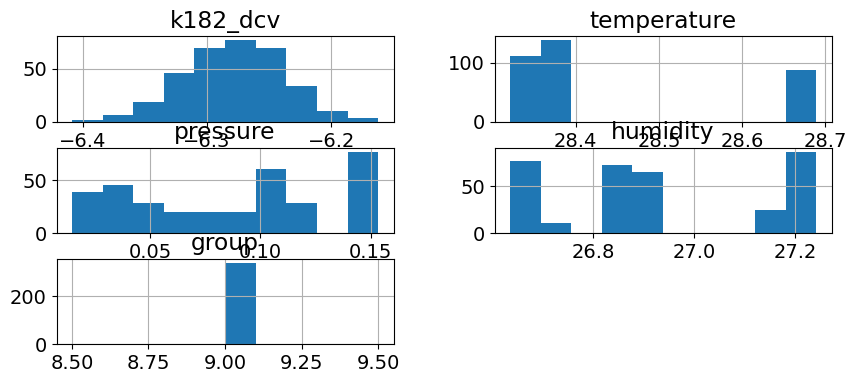

In [18]:
sample = k182_rel_data_cut[(k182_rel_data_cut.group == 9) & ((k182_rel_data_cut.dut_neg_lead == 'D4910avg') | (k182_rel_data_cut.dut_pos_lead == 'D4910avg')) & ((k182_rel_data_cut.dut_neg_lead == 'F7001bat') | (k182_rel_data_cut.dut_pos_lead == 'F7001bat'))].copy()
sample[sample.dut_pos_lead == 'F7001bat'].hist()
sample['sign'] = (sample.k182_dcv / sample.k182_dcv.abs())
res = sample.groupby(['dut_neg_lead', 'dut_pos_lead']).agg({'sign': 'unique'})
res['sign_length'] = res['sign'].apply(lambda r: len(r))
display(sample[(sample.dut_pos_lead == 'F7001bat') & (sample.k182_dcv < 0)])
display(sample[(sample.dut_pos_lead == 'F7001bat') & (sample.k182_dcv > 0)])
display(sample[(sample.dut_neg_lead == 'F7001bat') & (sample.k182_dcv < 0)])
display(sample[(sample.dut_neg_lead == 'F7001bat') & (sample.k182_dcv > 0)])